In [ ]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from dask.distributed import Client
import pprint 
# functions.ipynb contains functions to calculate ozone in dobzon units from mol/mol and the weight calculator
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/notebooks/func.ipynb
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/CMIP6_func.ipynb
%matplotlib inline

In [3]:
client.close()

NameError: name 'client' is not defined

In [4]:
client = Client(n_workers=5)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 62.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40413,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 62.81 GiB
Comm: tcp://127.0.0.1:35563,Total threads: 4
Dashboard: http://127.0.0.1:37765/status,Memory: 12.56 GiB
Nanny: tcp://127.0.0.1:37515,


## Open CMIP6 online catalog & download desired data

In [ ]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
waccm_aero = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['AERmon'], variable_id=['od550aer'])
cam_aero = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['AERmon'], variable_id=['od550aer'], member_id=['r1i1p1f1','r2i1p1f1','r3i1p1f1'])

waccm_aero.df
cam_aero.df

/srv/conda/envs/notebook/lib/python3.9/site-packages/intake_esm/search.py:106: UserWarning: Query returned zero results.
  warn(message)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version


In [6]:
ds_dict_waccm_Aero = waccm_aero.to_dataset_dict(zarr_kwargs={'use_cftime':True})
ds_dict_cam_aero = cam_aero.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
print(list(ds_dict_waccm_Aero.keys()))
print(list(ds_dict_cam_aero.keys()))
waccm_aod = ds_dict_waccm_Aero['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']
cam_aod = ds_dict_cam_aero['CMIP.NCAR.CESM2.historical.AERmon.gn']

['CMIP.NCAR.CESM2-WACCM.historical.AERmon.gn']
['CMIP.NCAR.CESM2.historical.AERmon.gn']


In [37]:
cam_aod


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, member_id: 3, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r2i1p1f1' 'r1i1p1f1' 'r3i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    od550aer   (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 307, 192, 288), meta=np.ndarray>
Attributes: (12/50)
    parent_experiment_id:    piControl
    tracking_id:             hdl:21.14100/70b57c59-18a6-40f1-973f-f28b4768329...
    table_id:                AERmon
    experiment_id:           historical
    branch_time_in_parent:   240900.0
    license:                 CMIP6 model data produced by <The National Cente...
    ...                      ...
    initialization_index:    1
    experiment:              all-forcing simulation of the recent past
    source_id:               CESM2
    source_type:             AOGCM BGC
    institution_id:          NCAR
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.AERmon.gn

In [8]:
yearly_waccm = waccm_aod.groupby('time.year').mean('time', keep_attrs=True)
yearly_cam = cam_aod.groupby('time.year').mean('time', keep_attrs=True)

In [9]:
# WACCM
year_NH_waccm_aod = computeWeightedMean(yearly_waccm.where(yearly_waccm['lat']>60.)).compute()
year_SH_waccm_aod = computeWeightedMean(yearly_waccm.where(yearly_waccm['lat']<-60.)).compute()

#CAM
year_NH_cam_aod = computeWeightedMean(yearly_cam.where(yearly_cam['lat']>60.)).compute()
year_SH_cam_aod = computeWeightedMean(yearly_cam.where(yearly_cam['lat']<-60.)).compute()

In [9]:
#WACCM
year_waccm_aod = computeWeightedMean(yearly_waccm).compute()

#CAM
year_cam_aod = computeWeightedMean(yearly_cam).compute()

In [16]:
#path = '/home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/'
#
#CESM_AOD = year_waccm_aod.od550aer.to_dataset(name='WACCM')
#CESM_AOD = CESM_AOD.merge(year_cam_aod.od550aer.to_dataset(name='CAM'))
#
#CESM_AOD.to_netcdf(path=path +'CESM_AOD.nc', mode='w',format='NETCDF4_CLASSIC',unlimited_dims='time')


In [20]:
eight_years = []
for i in np.arange(year_NH_waccm_aod.year[0],year_NH_waccm_aod.year[-1],8):
    eight_years.append(i)

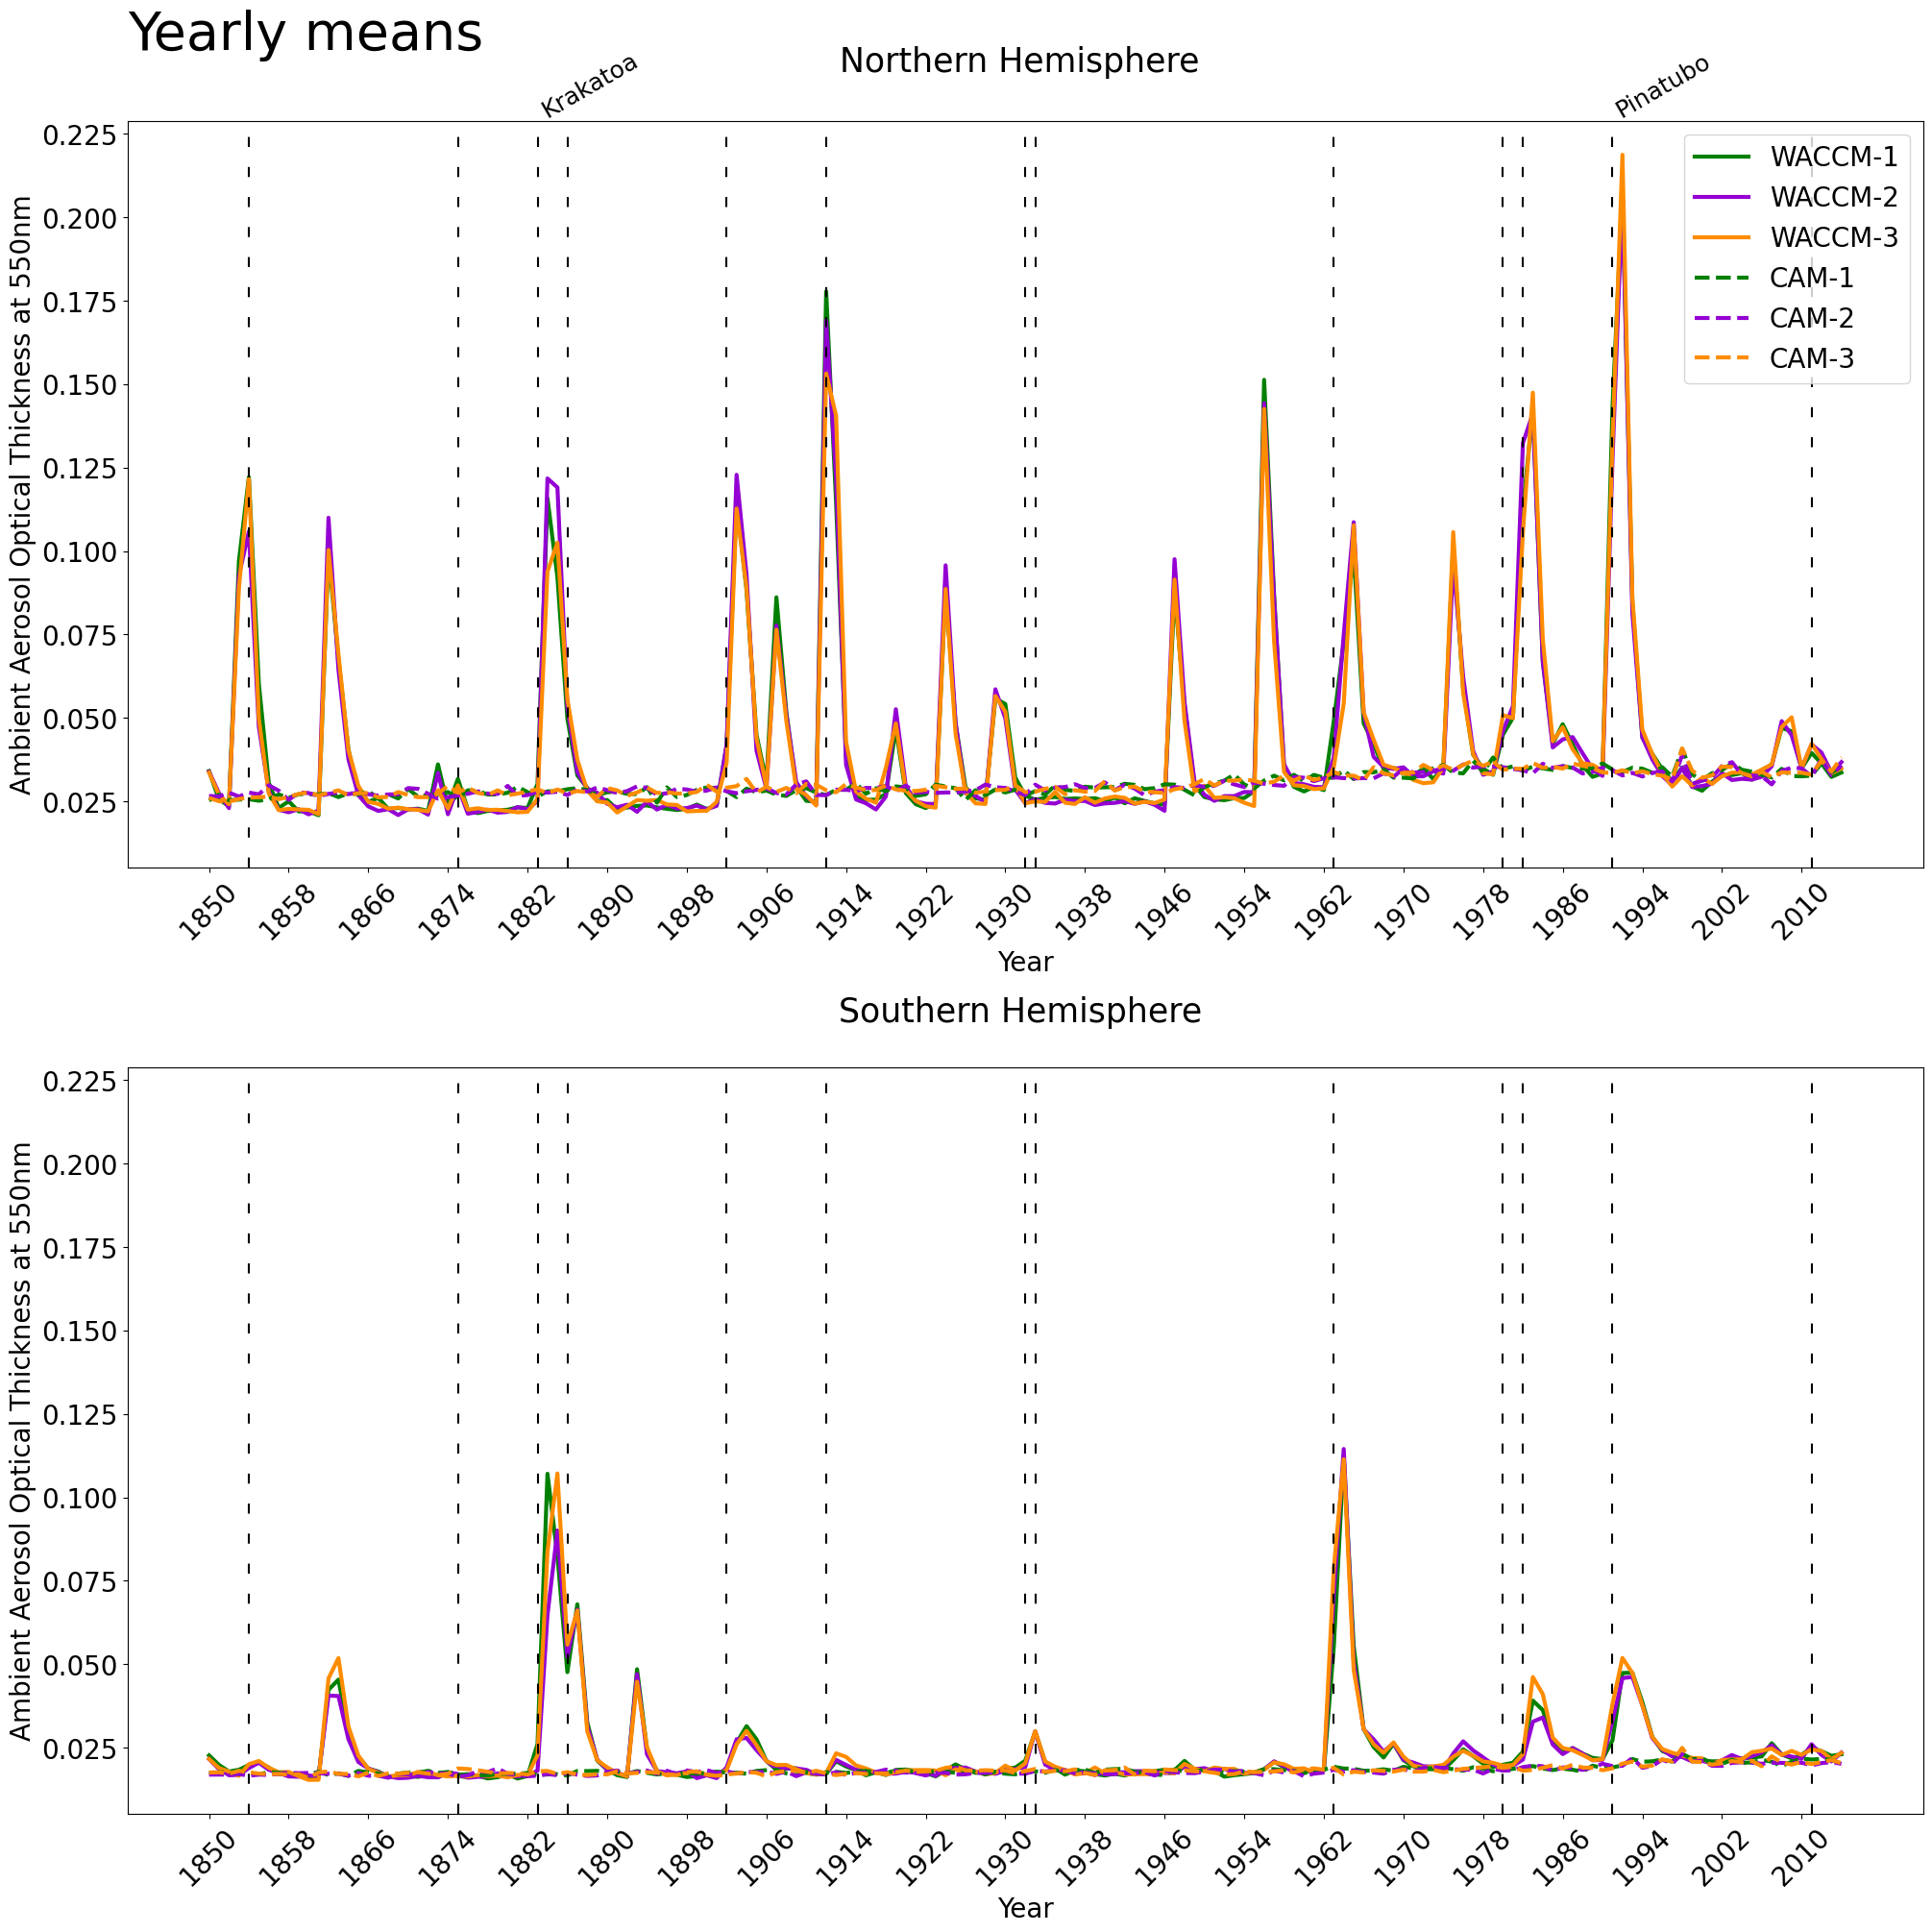

In [35]:
#fig, (axs1, axs2, axs3) = plt.subplots(3, 1, constrained_layout=True, sharey=True, figsize=(20,30))
fig, (axs1, axs2) = plt.subplots(2, 1, constrained_layout=True, sharey=True, figsize=(20,20))


color = ['green','darkviolet','darkorange']

for i in range(3):
    j = i+1
    year_NH_waccm_aod.od550aer[i].plot(label='WACCM-'+ str(j), ax=axs1, linewidth=3, color=color[i])
    year_SH_waccm_aod.od550aer[i].plot(label='WACCM-'+ str(j), ax=axs2, linewidth=3, color=color[i])

for i in range(3):
    j = i+1
    year_NH_cam_aod.od550aer[i].plot(label='CAM-'+ str(j), ax=axs1, linestyle='--', linewidth=3, color=color[i])
    year_SH_cam_aod.od550aer[i].plot(label="CAM-"+ str(j), ax=axs2, linestyle='--', linewidth=3, color=color[i])
    
#for i in range(3):
#    j = i+1
#    year_waccm_aod.od550aer[i].plot(label='WACCM-'+ str(j), ax=axs3, linewidth=3, color=color[i])
#    year_cam_aod.od550aer[i].plot(label="CAM-"+ str(j), ax=axs3, linestyle='--', linewidth=3, color=color[i])

eruptions = [1854,1875,1883,1886,1902,1912,1932,1933,1963,1980,1982,1991,2011]
for k in eruptions:
    axs1.axvline(k, color='k',linestyle='--',dashes=(5, 10))
    axs2.axvline(k, color='k',linestyle='--',dashes=(5, 10))
    #axs3.axvline(k, color='k',linestyle='--',dashes=(5, 10))

#fig.suptitle('Yearly means\n', fontsize=40)
axs1.set_title('Yearly means\n', fontsize=40, loc='left')

axs1.text(1883, .23, 'Krakatoa', fontdict=None,fontsize=18,rotation=30)
axs1.text(1991, .23, 'Pinatubo', fontdict=None,fontsize=18,rotation=30)

axs1.set_xticks(eight_years)
axs2.set_xticks(eight_years)

axs1.tick_params(axis='x', labelrotation = 45)
axs2.tick_params(axis='x', labelrotation = 45)

axs1.set_ylabel(year_NH_waccm_aod.od550aer.long_name, fontsize=20)
axs2.set_ylabel(year_NH_cam_aod.od550aer.long_name, fontsize=20)
#axs3.set_ylabel(year_cam_aod.od550aer.long_name, fontsize=20)

axs1.set_xlabel('Year', fontsize=20)
axs2.set_xlabel('Year', fontsize=20)
#axs3.set_xlabel('Year', fontsize=20)

axs1.tick_params(axis="x", labelsize=20)
axs2.tick_params(axis="x", labelsize=20)
#axs3.tick_params(axis="x", labelsize=20)

axs1.tick_params(axis="y", labelsize=20)
axs2.tick_params(axis="y", labelsize=20)
#axs3.tick_params(axis="y", labelsize=20)

axs1.set_title("Northern Hemisphere \n" , fontsize=25)
axs2.set_title("Southern Hemisphere \n" , fontsize=25)
#axs3.set_title("\n\n\nGlobal \n" , fontsize=25)

axs1.legend(fontsize=20)
path = '/home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/'
#plt.savefig(path + 'AOD_yearly.png')


# Krakatoa eruption in 1883

In [17]:
# Select the starting year 5 years prior to the eruption
start_krak = cftime.DatetimeNoLeap(1878,1,15)
end_krak = cftime.DatetimeNoLeap(1888,1,15)

# WACCM
waccm_1877_1887_aod = waccm_aod.sel(time=slice(start_krak, end_krak)).od550aer
# CAM
cam_1877_1887_aod = cam_aod.sel(time=slice(start_krak, end_krak)).od550aer

In [18]:
year_waccm_anom_1877_1887_aod = calc_yearly_anomaly(waccm_1877_1887_aod,1991)
year_cam_anom_1877_1887_aod = calc_yearly_anomaly(cam_1877_1887_aod,1991)

mon_waccm_anom_1877_1887_aod = calc_monthly_anomaly(waccm_1877_1887_aod,1991)
mon_cam_anom_1877_1887_aod = calc_monthly_anomaly(cam_1877_1887_aod,1991)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


In [19]:
# Yearly
# WACCM
year_waccm_NH_anom_krak_aod= computeWeightedMean(year_waccm_anom_1877_1887_aod.where(year_waccm_anom_1877_1887_aod['lat']>60.)).compute()
year_waccm_SH_anom_krak_aod= computeWeightedMean(year_waccm_anom_1877_1887_aod.where(year_waccm_anom_1877_1887_aod['lat']<-60.)).compute()

# CAM
year_cam_NH_anom_krak_aod = computeWeightedMean(year_cam_anom_1877_1887_aod.where(year_cam_anom_1877_1887_aod['lat']>60.)).compute()
year_cam_SH_anom_krak_aod = computeWeightedMean(year_cam_anom_1877_1887_aod.where(year_cam_anom_1877_1887_aod['lat']<-60.)).compute()

## Calculate the weight for the northern and southern hemispheres

In [20]:
# WACCM
mon_waccm_NH_anom_krak_aod= computeWeightedMean(mon_waccm_anom_1877_1887_aod.where(mon_waccm_anom_1877_1887_aod['lat']>60.)).compute()
mon_waccm_SH_anom_krak_aod= computeWeightedMean(mon_waccm_anom_1877_1887_aod.where(mon_waccm_anom_1877_1887_aod['lat']<-60.)).compute()

# CAM
mon_cam_NH_anom_krak_aod = computeWeightedMean(mon_cam_anom_1877_1887_aod.where(mon_cam_anom_1877_1887_aod['lat']>60.)).compute()
mon_cam_SH_anom_krak_aod = computeWeightedMean(mon_cam_anom_1877_1887_aod.where(mon_cam_anom_1877_1887_aod['lat']<-60.)).compute()

In [25]:
#path = '/home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/'
#
#WACCM_1877_1887_aod = mon_waccm_NH_anom_krak_aod.to_dataset(name='mon_NH_anom')
#WACCM_1877_1887_aod = WACCM_1877_1887_aod.merge(mon_waccm_SH_anom_krak_aod.to_dataset(name='mon_SH_anom'))
#WACCM_1877_1887_aod = WACCM_1877_1887_aod.merge(year_waccm_NH_anom_krak_aod.to_dataset(name='year_NH_anom'))
#WACCM_1877_1887_aod = WACCM_1877_1887_aod.merge(year_waccm_SH_anom_krak_aod.to_dataset(name='year_SH_anom'))
#
#WACCM_1877_1887_aod.to_netcdf(path=path +'WACCM_1986_1996_aod.nc', mode='w',format='NETCDF4_CLASSIC',unlimited_dims='time')
#
#CAM_1877_1887_aod = mon_cam_NH_anom_krak_aod.to_dataset(name='mon_NH_anom')
#CAM_1877_1887_aod = CAM_1877_1887_aod.merge(mon_cam_SH_anom_krak_aod.to_dataset(name='mon_SH_anom'))
#CAM_1877_1887_aod = CAM_1877_1887_aod.merge(year_cam_NH_anom_krak_aod.to_dataset(name='year_NH_anom'))
#CAM_1877_1887_aod = CAM_1877_1887_aod.merge(year_cam_SH_anom_krak_aod.to_dataset(name='year_SH_anom'))
#
#CAM_1877_1887_aod.to_netcdf(path=path +'CAM_1986_1996_aod.nc', mode='w',format='NETCDF4_CLASSIC',unlimited_dims='time')

In [28]:
waccm_krak_aod = xr.open_dataset('WACCM_1986_1996_aod.nc')
cam_krak_aod = xr.open_dataset('CAM_1986_1996_aod.nc')

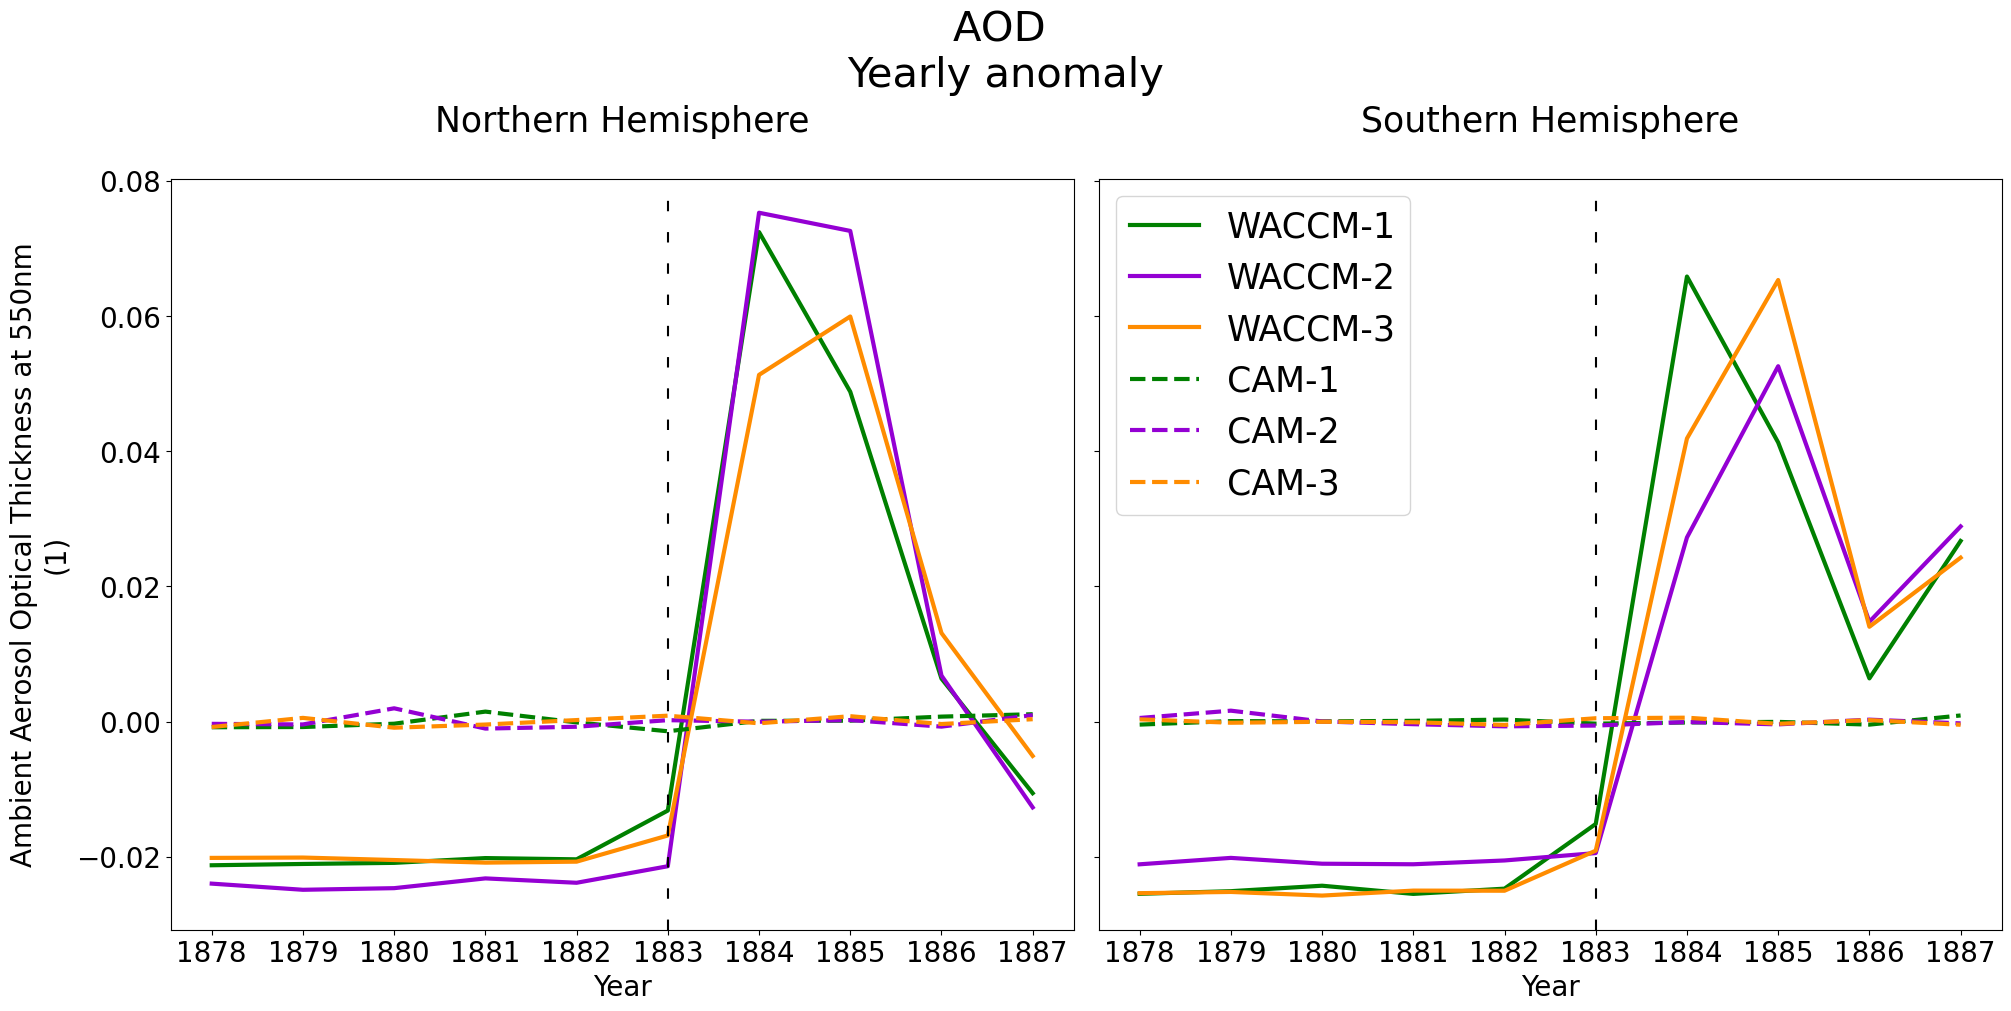

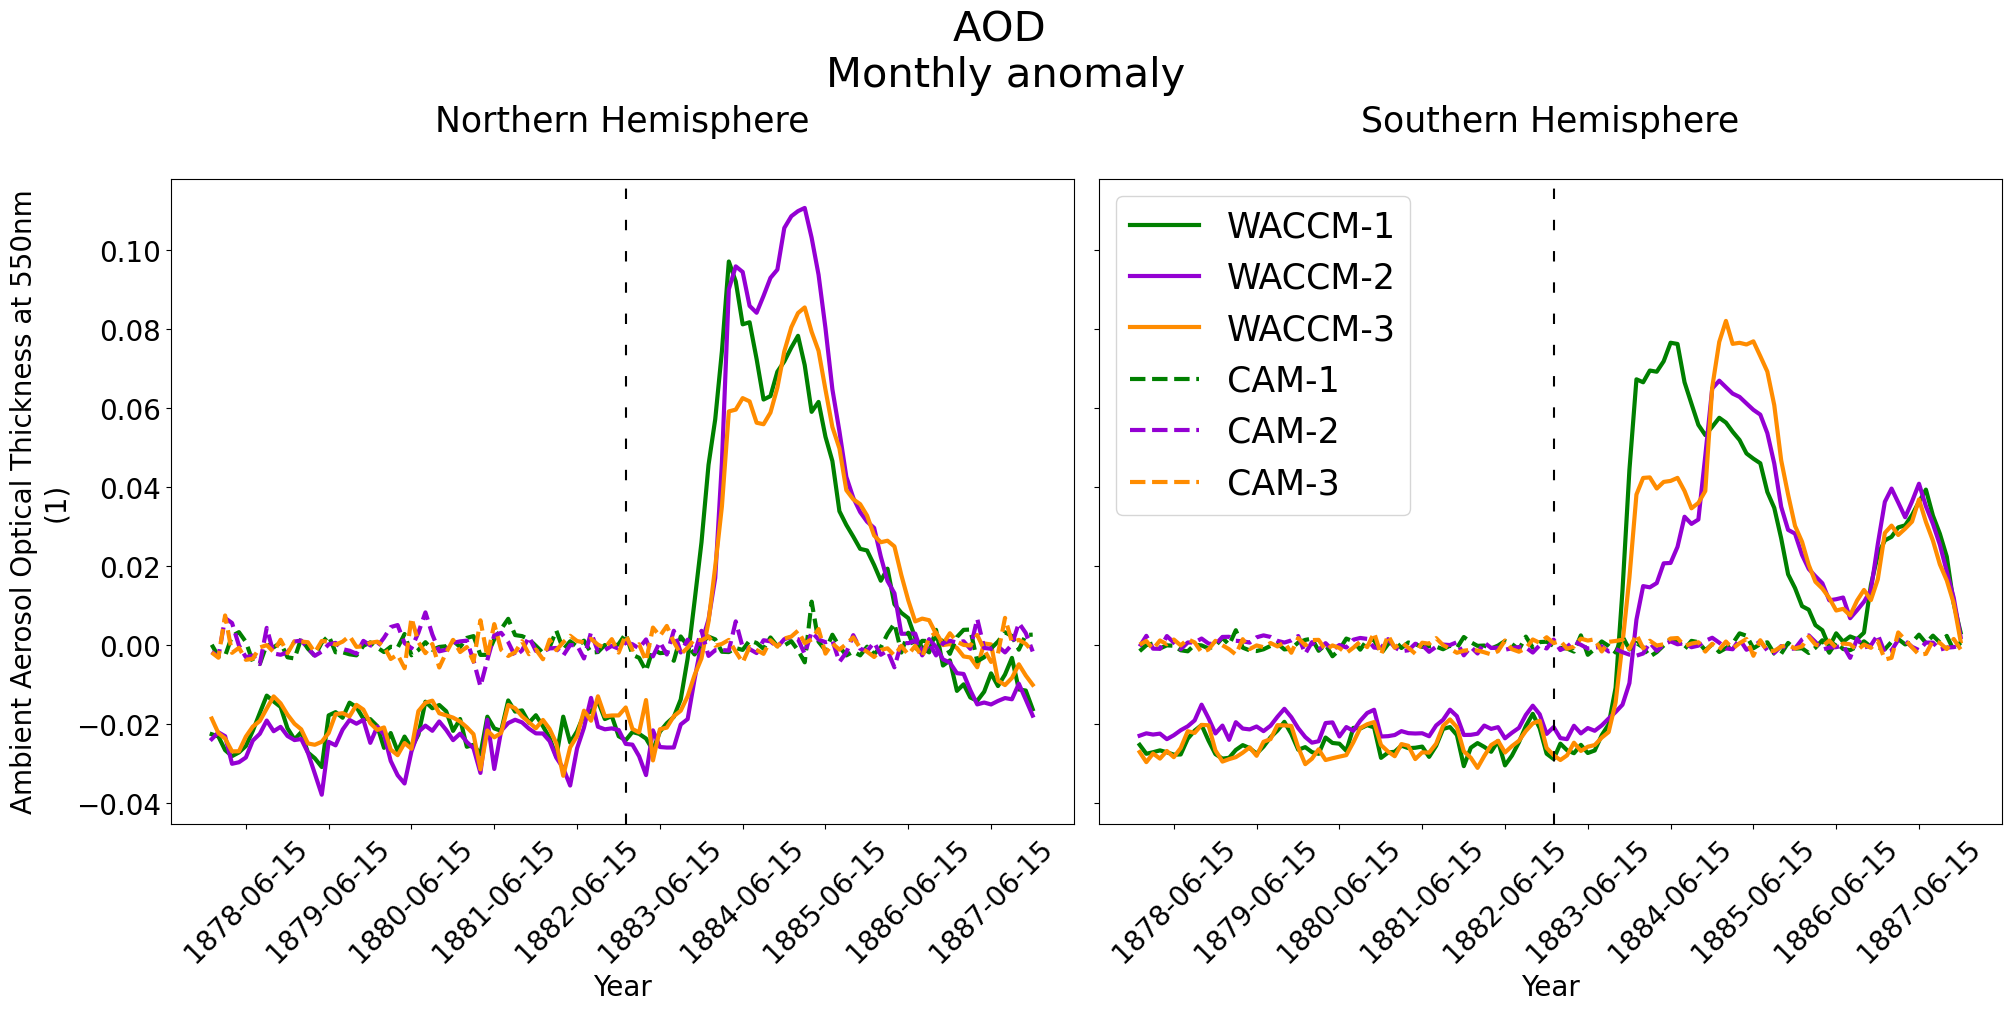

In [47]:
plot_year(year_waccm_NH_anom_krak_aod,year_waccm_SH_anom_krak_aod,year_cam_NH_anom_krak_aod,year_cam_SH_anom_krak_aod,'AOD \nYearly anomaly')
#plt.savefig(path + 'AOD_krak_yearly.png')

plot_month(mon_waccm_NH_anom_krak_aod,mon_waccm_SH_anom_krak_aod,mon_cam_NH_anom_krak_aod,mon_cam_SH_anom_krak_aod,'AOD \nMonthly anomaly')
#plt.savefig(path + 'AOD_krak_monthly.png')

# Pinatubo eruption in 1991

In [34]:
# Select the starting year 5 years prior to the eruption
start_pina = cftime.DatetimeNoLeap(1986,1,15)
end_pina = cftime.DatetimeNoLeap(1996,1,15)

# WACCM
waccm_1986_1996_aod = waccm_aod.sel(time=slice(start_pina, end_pina)).od550aer
# CAM
cam_1986_1996_aod = cam_aod.sel(time=slice(start_pina, end_pina)).od550aer

In [35]:
year_waccm_anom_1986_1996_aod = calc_yearly_anomaly(waccm_1986_1996_aod,1991)
year_cam_anom_1986_1996_aod = calc_yearly_anomaly(cam_1986_1996_aod,1991)

mon_waccm_anom_1986_1996_aod = calc_monthly_anomaly(waccm_1986_1996_aod,1991)
mon_cam_anom_1986_1996_aod = calc_monthly_anomaly(cam_1986_1996_aod,1991)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


## Calculate the weight for the northern and southern hemispheres

In [40]:
# Yearly
# WACCM
year_waccm_NH_anom_pina_aod= computeWeightedMean(year_waccm_anom_1986_1996_aod.where(year_waccm_anom_1986_1996_aod['lat']>60.)).compute()
year_waccm_SH_anom_pina_aod= computeWeightedMean(year_waccm_anom_1986_1996_aod.where(year_waccm_anom_1986_1996_aod['lat']<-60.)).compute()

# CAM
year_cam_NH_anom_pina_aod = computeWeightedMean(year_cam_anom_1986_1996_aod.where(year_cam_anom_1986_1996_aod['lat']>60.)).compute()
year_cam_SH_anom_pina_aod = computeWeightedMean(year_cam_anom_1986_1996_aod.where(year_cam_anom_1986_1996_aod['lat']<-60.)).compute()

In [42]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
mon_waccm_NH_anom_pina_aod= computeWeightedMean(mon_waccm_anom_1986_1996_aod.where(mon_waccm_anom_1986_1996_aod['lat']>60.)).compute()
mon_waccm_SH_anom_pina_aod= computeWeightedMean(mon_waccm_anom_1986_1996_aod.where(mon_waccm_anom_1986_1996_aod['lat']<-60.)).compute()

# CAM
mon_cam_NH_anom_pina_aod = computeWeightedMean(mon_cam_anom_1986_1996_aod.where(mon_cam_anom_1986_1996_aod['lat']>60.)).compute()
mon_cam_SH_anom_pina_aod = computeWeightedMean(mon_cam_anom_1986_1996_aod.where(mon_cam_anom_1986_1996_aod['lat']<-60.)).compute()

In [43]:
path = '/home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/'

WACCM_1986_1996_aod = mon_waccm_NH_anom_pina_aod.to_dataset(name='mon_NH_anom')
WACCM_1986_1996_aod = WACCM_1986_1996_aod.merge(mon_waccm_SH_anom_pina_aod.to_dataset(name='mon_SH_anom'))
WACCM_1986_1996_aod = WACCM_1986_1996_aod.merge(year_waccm_NH_anom_pina_aod.to_dataset(name='year_NH_anom'))
WACCM_1986_1996_aod = WACCM_1986_1996_aod.merge(year_waccm_SH_anom_pina_aod.to_dataset(name='year_SH_anom'))

WACCM_1986_1996_aod.to_netcdf(path=path +'WACCM_1986_1996_aod.nc', mode='w',format='NETCDF4_CLASSIC',unlimited_dims='time')

CAM_1986_1996_aod = mon_cam_NH_anom_pina_aod.to_dataset(name='mon_NH_anom')
CAM_1986_1996_aod = CAM_1986_1996_aod.merge(mon_cam_SH_anom_pina_aod.to_dataset(name='mon_SH_anom'))
CAM_1986_1996_aod = CAM_1986_1996_aod.merge(year_cam_NH_anom_pina_aod.to_dataset(name='year_NH_anom'))
CAM_1986_1996_aod = CAM_1986_1996_aod.merge(year_cam_SH_anom_pina_aod.to_dataset(name='year_SH_anom'))

CAM_1986_1996_aod.to_netcdf(path=path +'CAM_1986_1996_aod.nc', mode='w',format='NETCDF4_CLASSIC',unlimited_dims='time')

PermissionError: [Errno 13] Permission denied: b'/home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/WACCM_1986_1996_aod.nc'

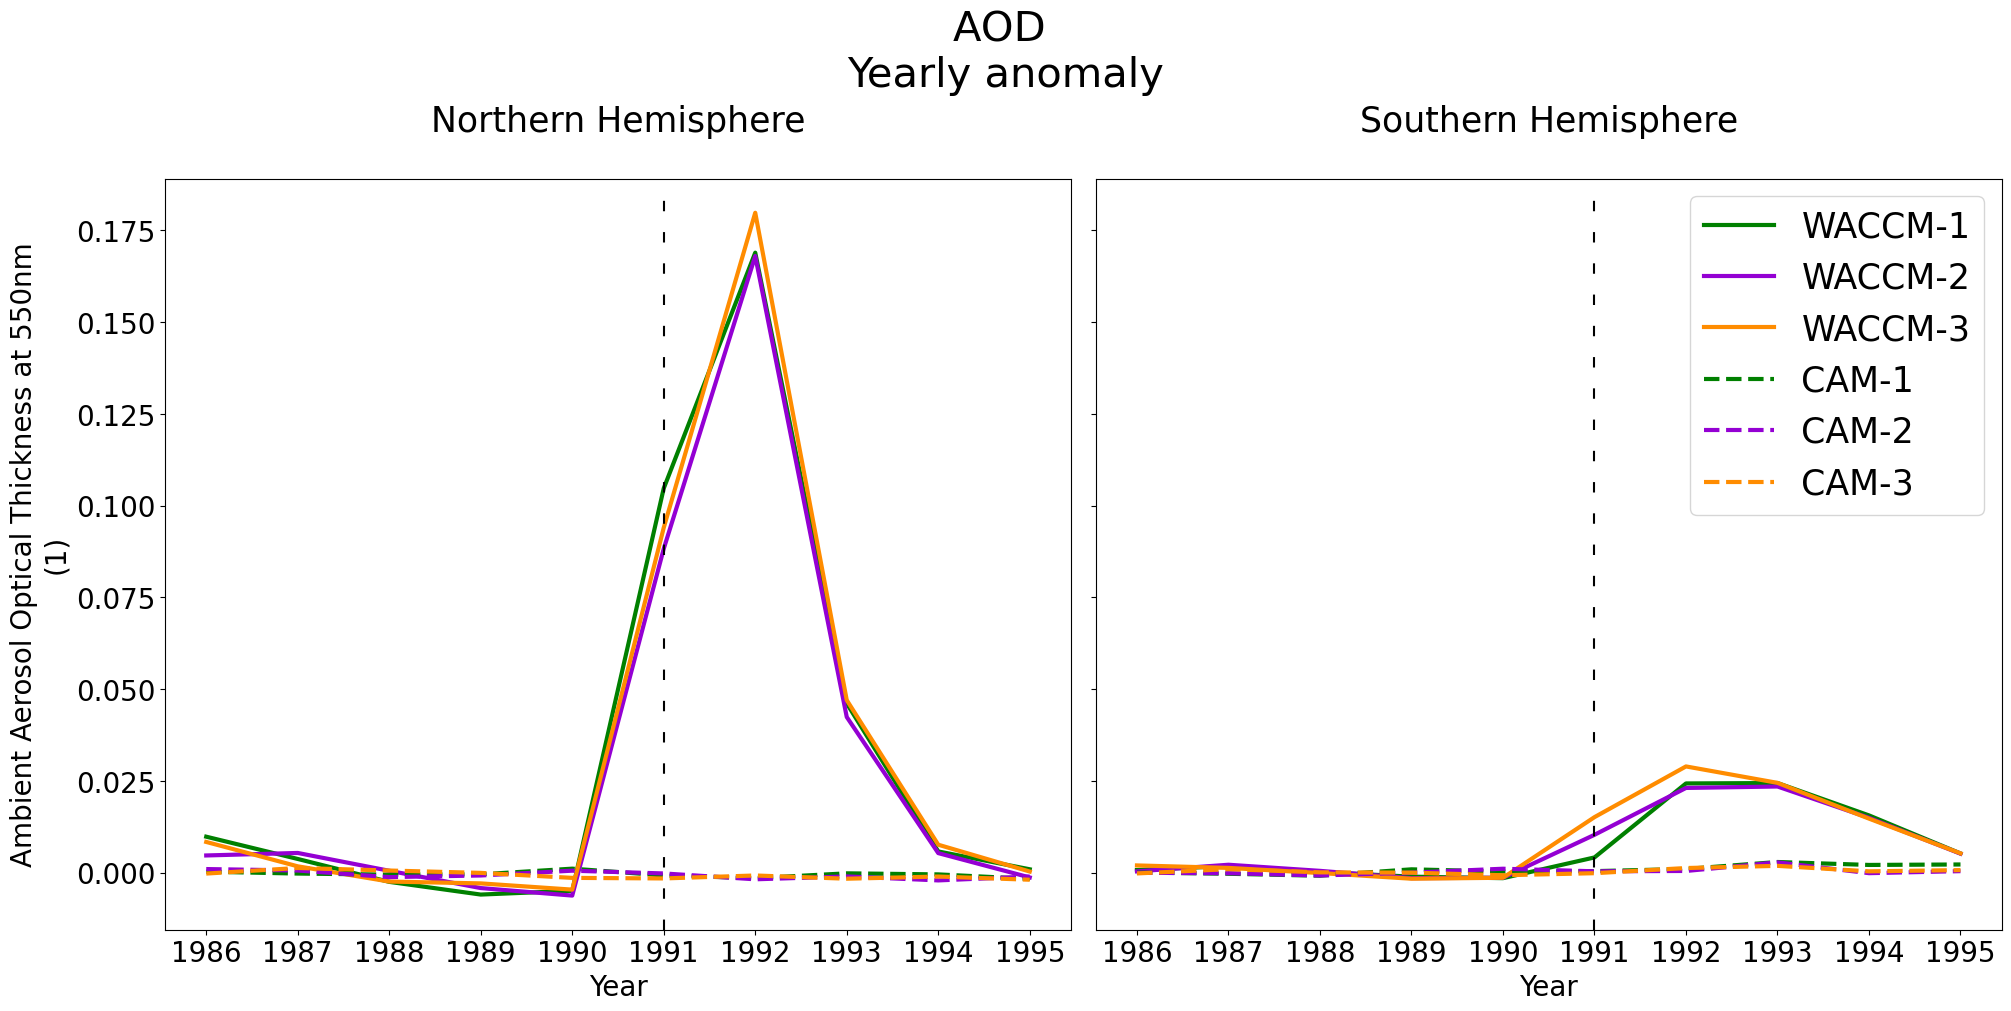

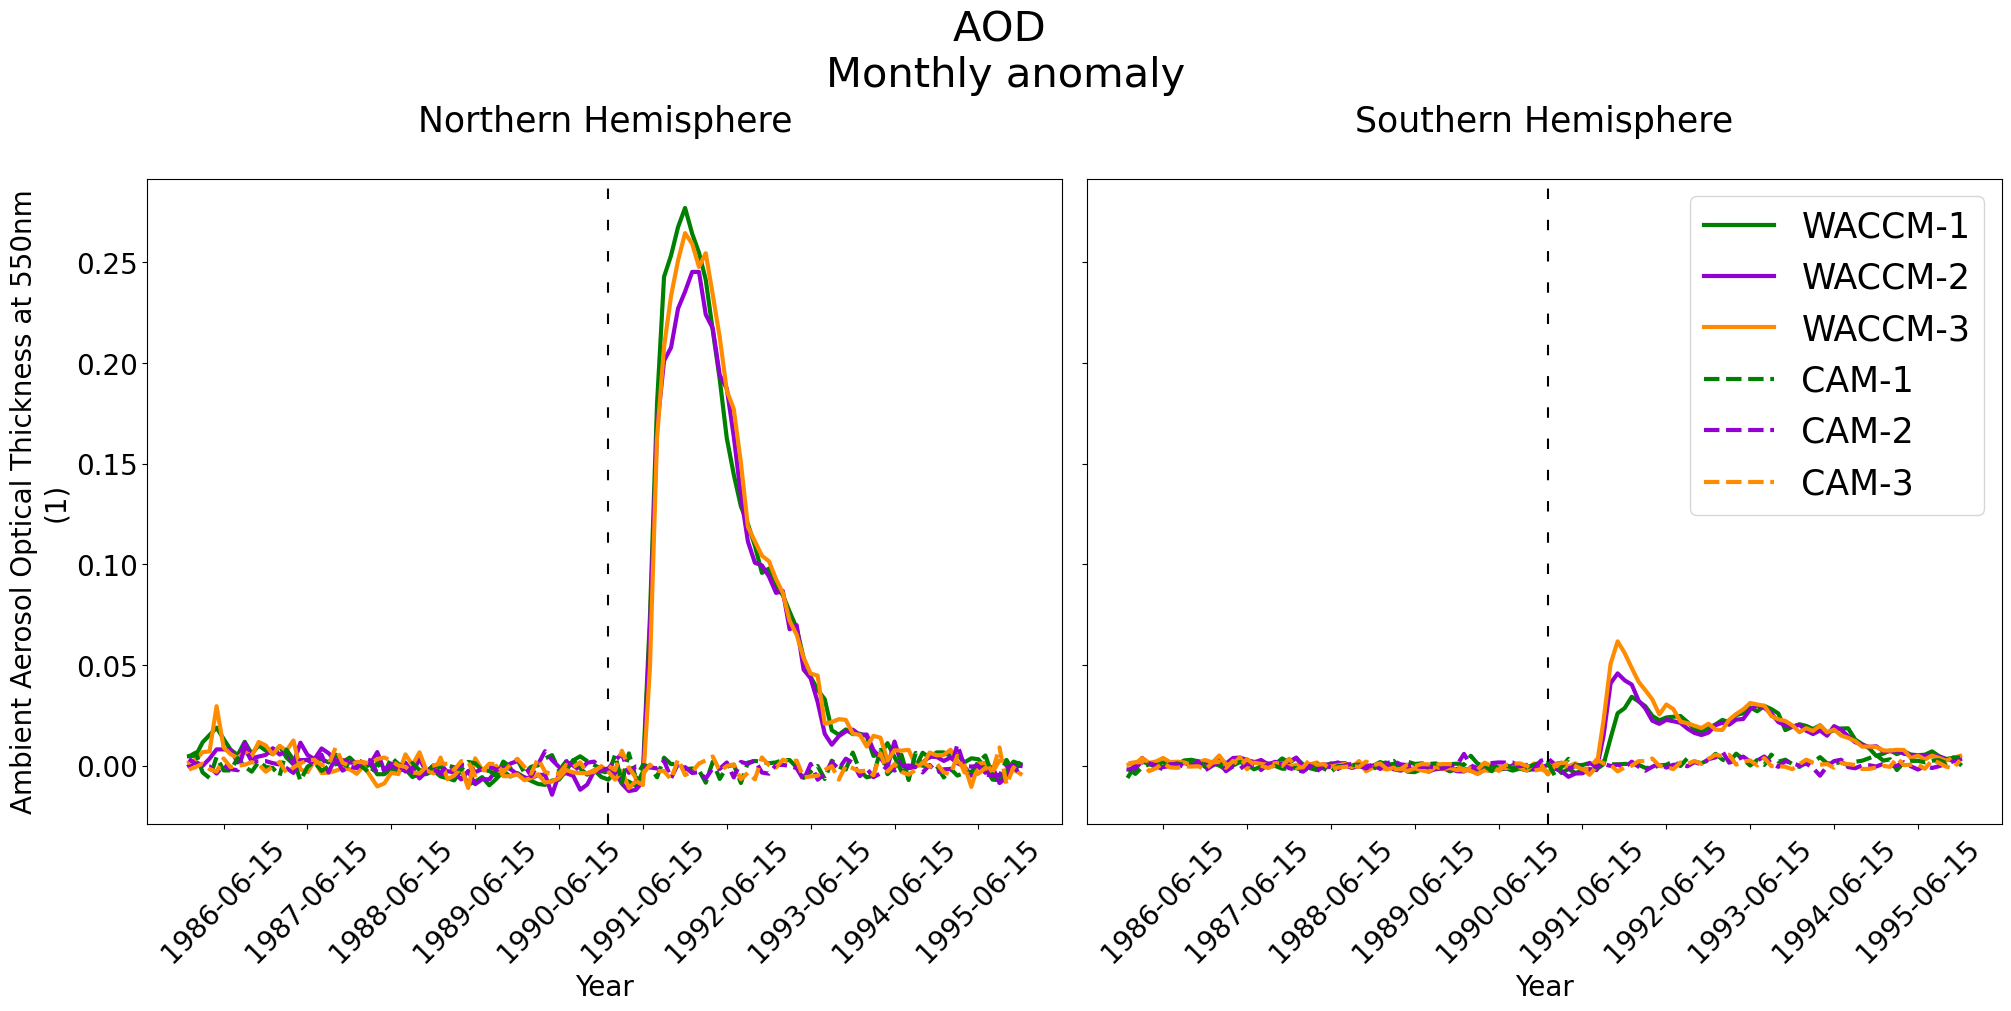

In [45]:
plot_year(year_waccm_NH_anom_aod,year_waccm_SH_anom_aod,year_cam_NH_anom_aod,year_cam_SH_anom_aod,'AOD \nYearly anomaly')
plt.savefig(path + 'AOD_pina_yearly.png')

plot_month(mon_waccm_NH_anom_aero,mon_waccm_SH_anom_aero,mon_cam_NH_anom_aod,mon_cam_SH_anom_aod,'AOD \nMonthly anomaly')
plt.savefig(path + 'AOD_pina_monthly.png')